# Notebook for baseline U-Net and Data-Augmented U-Net

The following notebook has been devloped and run in Google Colab.

In [ ]:
# ONLY USE IF RUNNING IN GOOGLE COLAB

# Clone of repo
!git clone https://github.com/JustavGunker/02456-final-project.git

# Set directory
import os
os.chdir("/content/02456-final-project")

Cloning into '02456-final-project'...
remote: Enumerating objects: 7865, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 7865 (delta 14), reused 19 (delta 6), pack-reused 7819 (from 4)
Receiving objects: 100% (7865/7865), 2.10 GiB | 27.82 MiB/s, done.
Resolving deltas: 100% (883/883), done.
Updating files: 100% (6687/6687), done.


### Dataset class and libraries

In [1]:
import os
import torch
import tifffile as tiff
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt


class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, resize=(768, 768), augment = False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize = resize
        self.augment = augment

        # List of image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])

        # Match masks by replacing 'image_v2_' with 'image_v2_mask_'
        mask_dir_files = os.listdir(mask_dir)
        self.mask_files = []
        for img_name in self.image_files:
            mask_name = img_name.replace('image_v2_', 'image_v2_mask_')
            if mask_name not in mask_dir_files:
                raise FileNotFoundError(f"Mask {mask_name} not found for image {img_name}")
            self.mask_files.append(mask_name)

        assert len(self.image_files) == len(self.mask_files), "Image and mask count mismatch!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load TIFF images
        image = tiff.imread(img_path)
        mask = tiff.imread(mask_path)

        # If 3D stack, take middle slice
        if image.ndim == 3:
            image = image[image.shape[0] // 2]

        # Contrast stretch image to 0-1
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)*255
        image = torch.from_numpy(image).float()

        # Convert mask to tensor
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)*255
        mask = ((mask < 4) | (mask == 118.005585) | (mask == 116.12109375) ).astype(np.float32)
        mask = torch.from_numpy(mask).float()

        # Add channel dimension to image if grayscale
        if image.ndim == 2:
            image = image.unsqueeze(0)  # C x H x W
        else:
            image = image.permute(2,0,1)  # HWC -> CHW

        # Resize image and mask
        image = F.interpolate(image.unsqueeze(0), size=self.resize, mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=self.resize, mode='nearest').squeeze(0).float()

        # Augementation
        if self.augment:
            image, mask = random_augment(image, mask)

        return image, mask

### Augmentation function

In [2]:
import random

def random_augment(image, mask):
    """
    image: torch tensor, shape [C,H,W]
    mask:  torch tensor, shape [H,W] eller [1,H,W]
    return: augmented image, mask i samme format som input
    """

    # Ensure mask has channel dimension
    mask_was_2d = False
    if mask.ndim == 2:
        mask = mask.unsqueeze(0)   # [1,H,W]
        mask_was_2d = True

    # 1) Random horizontal flip
    if random.random() < 0.5:
        # dims: [C,H,W] → dim=2 is W
        image = torch.flip(image, dims=[2])
        mask  = torch.flip(mask,  dims=[2])

    # 2) Random vertical flip
    if random.random() < 0.5:
        # dims: [C,H,W] → dim=1 is H
        image = torch.flip(image, dims=[1])
        mask  = torch.flip(mask,  dims=[1])

    # 3) Random rotation (0, 90, 180, 270 degrees)
    k = random.choice([0, 1, 2, 3])  # 0=0°, 1=90°, 2=180°, 3=270°
    if k != 0:
        # Rotate over (H,W)-dimensions
        image = torch.rot90(image, k=k, dims=(1, 2))
        mask  = torch.rot90(mask,  k=k, dims=(1, 2))

    # 4) Random brightness & contrast (mild)
    if random.random() < 0.5:
        # brightness shift: +/- 20%
        brightness_factor = 1.0 + 0.20 * (random.random() - 0.5)
        # contrast shift: +/- 20%
        contrast_factor   = 1.0 + 0.20 * (random.random() - 0.5)

        image = image * contrast_factor + brightness_factor * 10.0
        image = torch.clamp(image, 0, 255)

    # 5) Random Gaussian noise
    if random.random() < 0.5:
        noise_std = 0.03 * torch.std(image)
        noise = torch.randn_like(image) * noise_std
        image = torch.clamp(image + noise, 0, 255)


    # Remove channel-dim again if it was 2D to start with
    if mask_was_2d:
        mask = mask.squeeze(0)

    return image, mask





### Initializer to switch data-augmentation on/off. Sets seed for reproducibility


In [3]:
# Load data, and choose if we want to augment or not

# -------- MADE WITH AI BUT REVIEWED


# Start with same seed for reproducibility:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# SEED function for dataloaders, to recreate same data-split
def seed_worker(worker_id):
    np.random.seed(SEED)
    random.seed(SEED)
    torch.manual_seed(SEED)

g = torch.Generator()
g.manual_seed(SEED)


# --------------------------------
# 0) Config: turn augmentation on/off
# --------------------------------
USE_AUG = False   # set to False to train without augmentation

# --------------------------------
# 1) Paths
# --------------------------------
#image_dir = "archive/Original_images"
#mask_dir  = "archive/Original_masks"

image_dir = "../../archive/Original_images" # these paths if not using colab
mask_dir  = "../../archive/Original_masks" # these paths if not using colab


# --------------------------------
# 2) Base dataset (no augmentation)
#    Used only to define length and splitting indices
# --------------------------------
base_dataset = ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False)

# You can print this once to sanity-check shapes
base_loader = DataLoader(base_dataset, batch_size=4, shuffle=True, num_workers=0)
images, masks = next(iter(base_loader))
print("Base image batch shape:", images.shape)
print("Base mask batch shape:", masks.shape)

# --------------------------------
# 3) Split indices into train / val / test
# --------------------------------
train_size = int(0.8 * len(base_dataset))
val_size   = int(0.1 * len(base_dataset))
test_size  = len(base_dataset) - train_size - val_size


train_subset, val_subset, test_subset = random_split(
    range(len(base_dataset)), [train_size, val_size, test_size], generator=g
)

train_indices = list(train_subset)
val_indices   = list(val_subset)
test_indices  = list(test_subset)

# --------------------------------
# 4) Build datasets for each split
#    - Train: augment = USE_AUG (True or False)
#    - Val/Test: always clean (augment=False)
# --------------------------------
train_dataset = Subset(
    ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=USE_AUG),
    train_indices
)

val_dataset = Subset(
    ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False),
    val_indices
)

test_dataset = Subset(
    ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False),
    test_indices
)

# --------------------------------
# 5) Dataloaders, remove worker init and generator for
# --------------------------------
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False, worker_init_fn=seed_worker, generator=g)

# --------------------------------
# 6) Optional: expose a dataset handle for visualization
#    - If you want to inspect raw data: use base_dataset
#    - If you want to inspect training data (with/without aug): use train_dataset.dataset
# --------------------------------
dataset = train_dataset.dataset   # this is an ImageMaskDataset with augment=USE_AUG

print(f"USE_AUG = {USE_AUG}")
print("Train batch image shape:", next(iter(train_loader))[0].shape)
print("Train batch mask shape:",  next(iter(train_loader))[1].shape)
print("dataset.augment:", dataset.augment)


Base image batch shape: torch.Size([4, 1, 512, 512])
Base mask batch shape: torch.Size([4, 1, 512, 512])
USE_AUG = False
Train batch image shape: torch.Size([6, 1, 512, 512])
Train batch mask shape: torch.Size([6, 1, 512, 512])
dataset.augment: False


In [5]:
# Data augmentation display

def show_image_and_mask(img, msk, ax_img, ax_msk, title=""):
    # img: [C,H,W], msk: [H,W] eller [1,H,W]
    img_np = img.squeeze(0).cpu().numpy()
    msk_np = msk.squeeze().cpu().numpy()

    ax_img.imshow(img_np, cmap="gray")
    ax_img.set_title(title)
    ax_img.axis("off")

    ax_msk.imshow(msk_np, cmap="gray")
    ax_msk.set_title("Mask")
    ax_msk.axis("off")

# choose random sample ID in dataset to displau
idx = 2
img, msk = dataset[idx]

# Number of augemented images
n_aug = 6

fig, axes = plt.subplots(n_aug + 1, 2, figsize=(6, 3*(n_aug+1)))
fig.suptitle(f"Original + {n_aug} augmentations (idx={idx})", fontsize=14)

# First row: original
show_image_and_mask(img, msk, axes[0,0], axes[0,1], title="Original")

# Other rows: different augmentations
for i in range(1, n_aug+1):
    img_aug, msk_aug = random_augment(img.clone(), msk.clone())
    show_image_and_mask(img_aug, msk_aug, axes[i,0], axes[i,1], title=f"Aug #{i}")

plt.tight_layout()
plt.show()


: 

In [4]:
# Debug to find which pixels greater than 50 appeared, to binarize masks
from collections import Counter

pixel_counter = Counter()

for i in range(len(dataset)):
    _, mask = dataset[i]
    mask_np = mask.numpy().squeeze()

    # Flatten and filter pixels > 50
    pixels_gt_50 = mask_np[mask_np > 50].flatten().tolist()

    # Update counter
    pixel_counter.update(pixels_gt_50)

# Get most common values
most_common = pixel_counter.most_common(3)

print("Most frequent pixel values > 50:")
for val, cnt in most_common:
    print(f"value={val} → count={cnt}")


Most frequent pixel values > 50:


### Model and loss function

In [5]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    """
    Two consecutive conv–BN–ReLU blocks with padding (same size).
    This preserves your structure exactly as before.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class unet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(unet, self).__init__()

        # Encoder (downsampling)
        self.conv_down1 = double_conv(in_channels, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)

        # Decoder (upsampling)
        self.up_trans4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_trans3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_trans2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_trans1 = nn.ConvTranspose2d(128, 64,  kernel_size=2, stride=2)

        # After concatenation (skip connection)
        self.conv_up4 = double_conv(512 + 512, 512)  # upsampled 512 + skip 512
        self.conv_up3 = double_conv(256 + 256, 256)
        self.conv_up2 = double_conv(128 + 128, 128)
        self.conv_up1 = double_conv(64  + 64,  64)

        # Final 1×1 convolution
        self.last_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.conv_down4(x)
        x = self.maxpool(conv4)

        x = self.conv_down5(x)

        # Decoder + skip connections (ORIGINAL U-NET)
        x = self.up_trans4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.conv_up4(x)

        x = self.up_trans3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)

        x = self.up_trans2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)

        x = self.up_trans1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv_up1(x)

        return self.last_conv(x)


In [6]:
# BCE + Dice combination loss for binary segmentation
class BCEDiceLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-7):
        """
        alpha: Weight between BCE and Dice loss.
               total_loss = alpha * BCE + (1 - alpha) * DiceLoss
        smooth: A small constant added to avoid division by zero.
        """
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()  # BCE loss that expects raw logits
        self.alpha = alpha
        self.smooth = smooth

    def forward(self, inputs, targets):
        # BCE
        # BCEWithLogitsLoss applies a sigmoid internally and computes BCE.
        bce_loss = self.bce(inputs, targets)

        # DICE
        # Apply sigmoid to convert logits into probabilities.
        probs = torch.sigmoid(inputs)

        # Ensure memory layout is contiguous for flattening.
        probs = probs.contiguous()
        targets = targets.contiguous()

        # Flatten tensors from [B, C, H, W] → [B, -1]
        probs_flat   = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        # Compute intersection and union for Dice calculation.
        intersection = (probs_flat * targets_flat).sum(dim=1)
        union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)

        # Dice coefficient.
        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)

        # Dice loss (we minimize 1 - Dice score).
        dice_loss = 1 - dice_score.mean()


        # Finally we have weighted sum of BCE and Dice.
        loss = self.alpha * bce_loss + (1 - self.alpha) * dice_loss
        return loss


### Training function

In [7]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, model_path):
    history = {k: [] for k in ["train_loss","val_loss","val_dice","val_iou","val_acc","val_sens","val_spec", "Epoch"]}

    # Register best loss and epoch
    best_loss = float("inf")
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        num_batches = len(train_loader)
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        dice_scores, iou_scores, acc_scores, sens_scores, spec_scores = [], [], [], [], []
        eps = 1e-7
        num_val_batches = len(val_loader)
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()
                targets = masks.float()

                intersection = (preds * targets).sum(dim=(1,2,3))
                pred_sum = preds.sum(dim=(1,2,3))
                mask_sum = targets.sum(dim=(1,2,3))
                union = ((preds + targets) > 0).float().sum(dim=(1,2,3))

                dice = (2*intersection + eps) / (pred_sum + mask_sum + eps)
                iou  = (intersection + eps) / (union + eps)

                tp = intersection
                tn = ((1 - preds) * (1 - targets)).sum(dim=(1,2,3))
                fp = (preds * (1 - targets)).sum(dim=(1,2,3))
                fn = ((1 - preds) * targets).sum(dim=(1,2,3))

                acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
                sens = (tp + eps) / (tp + fn + eps)
                spec = (tn + eps) / (tn + fp + eps)

                dice_scores.append(dice.mean().item())
                iou_scores.append(iou.mean().item())
                acc_scores.append(acc.mean().item())
                sens_scores.append(sens.mean().item())
                spec_scores.append(spec.mean().item())

        avg_train_loss = train_loss / num_batches
        avg_val_loss = val_loss / num_val_batches
        val_dice = float(np.mean(dice_scores))
        val_iou = float(np.mean(iou_scores))
        val_acc = float(np.mean(acc_scores))
        val_sens = float(np.mean(sens_scores))
        val_spec = float(np.mean(spec_scores))

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_dice"].append(val_dice)
        history["val_iou"].append(val_iou)
        history["val_acc"].append(val_acc)
        history["val_sens"].append(val_sens)
        history["val_spec"].append(val_spec)
        history["Epoch"].append(epoch)

        # Model stays on best validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_path)

        if epoch % 10 == 0:
          print(f"Epoch {epoch:03d}/{num_epochs} | "
                f"train_loss={avg_train_loss:.4f} | val_loss={avg_val_loss:.4f} | "
                f"Dice={val_dice:.4f} | IoU={val_iou:.4f} | "
                f"Acc={val_acc:.4f} | Sens={val_sens:.4f} | Spec={val_spec:.4f}")

    print(f"Best val_loss {best_loss:.4f} at epoch {best_epoch}")
    return history


In [9]:
# NOT NECESSARY TO RUN!

# Define model run to be saved later locally on Colab

run_name = "u-net_400epochs_BCEDice_run7"  # Set name

history_path = f"{logs_dir}/{run_name}.csv"
model_path   = f"{models_dir}/{run_name}.pth"

print("Model saved at: ", model_path)
print("History saved at: ", history_path)

NameError: name 'logs_dir' is not defined

In [10]:
# Run this cell if not using colab

models_dir = "../../Trained_models"
logs_dir = "../../Logs"

run_name = "u-net_400epochs_BCEDice_run7"  # Set name

history_path = f"{logs_dir}/{run_name}.csv"
model_path   = f"{models_dir}/{run_name}.pth"

### Training loop

In [ ]:
# Training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = unet().to(device)

# criterion = nn.BCEWithLogitsLoss()
criterion = BCEDiceLoss(alpha=0.5)   # 0.5/0.5 vægtning, kan justeres
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
num_epochs = 400

history = train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, model_path)


In [ ]:
# print best IoU, Dice Score and lowest losssfrom history
print(f"Best val_iou {max(history['val_iou']):.4f} at epoch {history['val_iou'].index(max(history['val_iou']))}")
print(f"Best val_dice {max(history['val_dice']):.4f} at epoch {history['val_dice'].index(max(history['val_dice']))}")
print(f"Best val_loss {min(history['val_loss']):.4f} at epoch {history['val_loss'].index(min(history['val_loss']))}")

# print mean IoU, Dice Score and loss from history
print(f"Mean val_iou {np.mean(history['val_iou']):.4f}")
print(f"Mean val_dice {np.mean(history['val_dice']):.4f}")
print(f"Mean val_loss {np.mean(history['val_loss']):.4f}")

Best val_iou 0.7564 at epoch 24
Best val_dice 0.8613 at epoch 24
Best val_loss 0.2180 at epoch 399
Mean val_iou 0.7182
Mean val_dice 0.8317
Mean val_loss 0.3169


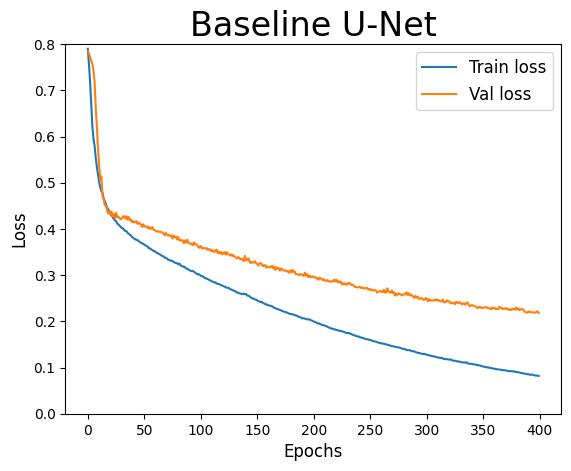

In [ ]:
title = "Baseline U-Net with augmentation" if dataset.augment else "Baseline U-Net"

plt.plot(history['Epoch'], history['train_loss'], label='Train loss')
plt.plot(history['Epoch'], history['val_loss'], label='Val loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, 0.8)
plt.title(title, fontsize=24)
plt.legend(fontsize=12)

### Predictions of segmentation masks

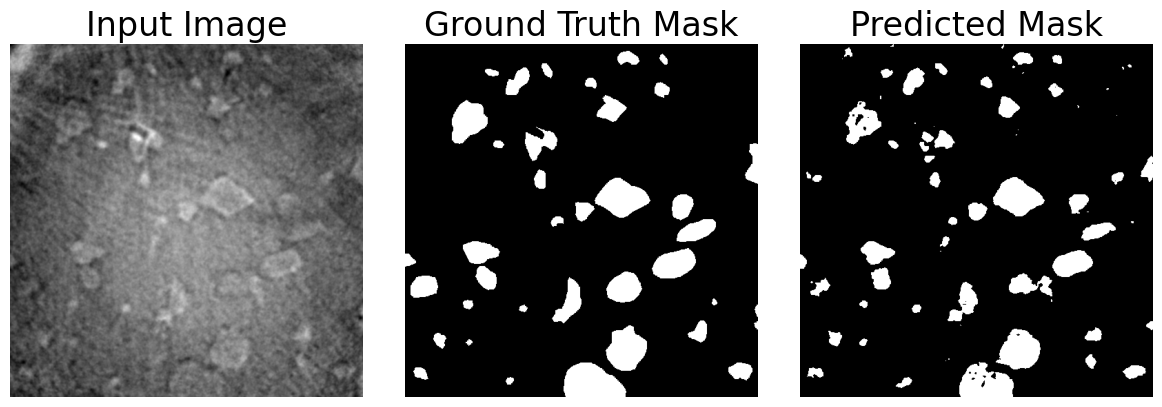

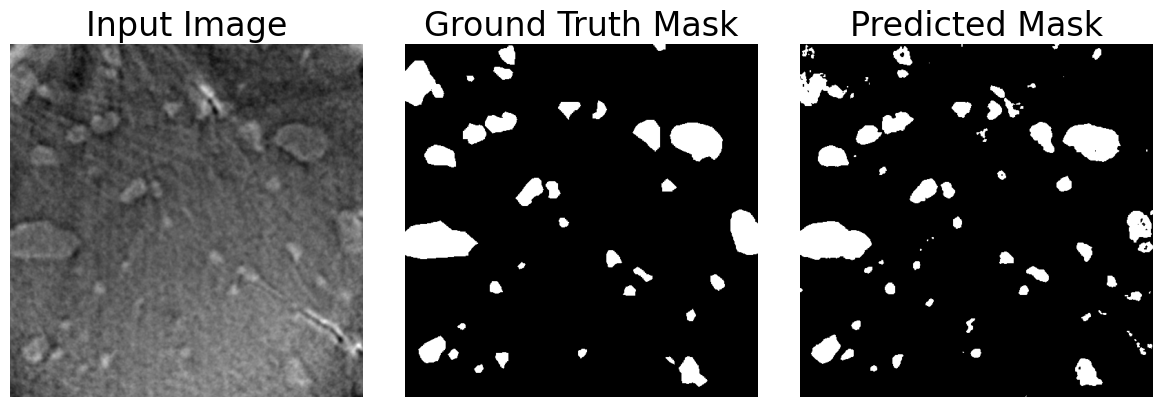

In [ ]:
# Plot of predictions

model.eval()  # set to eval mode

# Take one batch from the test loader
images, masks = next(iter(test_loader))  # images: [B,C,H,W], masks: [B,1,H,W]

for i in range(images.size(0)):
    image = images[i].to(device).unsqueeze(0)  # add batch dim
    mask = masks[i].to(device)

    with torch.no_grad():
        output = model(image)                  # [1,1,H,W]
        probs = torch.sigmoid(output)          # probabilities
        pred_mask = (probs > 0.5).float()     # binary mask

    # Move to CPU for plotting
    image_cpu = image.squeeze(0).cpu()
    mask_cpu = mask.cpu()
    pred_cpu = pred_mask.squeeze(0).cpu()

    # Plot
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(image_cpu.squeeze(0), cmap='gray')
    axs[0].set_title("Input Image", fontsize=24)
    axs[0].axis('off')

    axs[1].imshow(mask_cpu.squeeze(0), cmap='gray')
    axs[1].set_title("Ground Truth Mask", fontsize=24)
    axs[1].axis('off')

    axs[2].imshow(pred_cpu.squeeze(0), cmap='gray')
    axs[2].set_title("Predicted Mask", fontsize=24)
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

Best epoch: 399
  val_loss = 0.2180
  Dice     = 0.8409
  IoU      = 0.7256


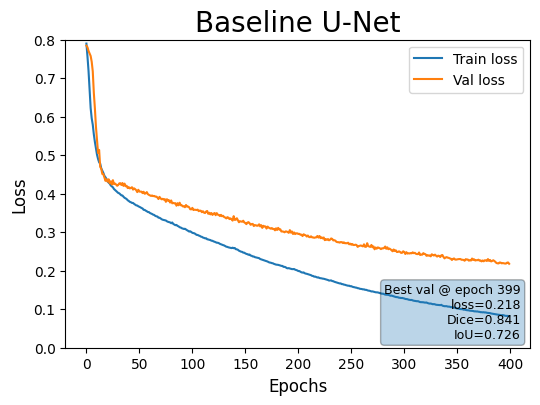

In [ ]:
# Plot of train-val-loss AND metrics

epochs   = np.array(history["Epoch"])
val_loss = np.array(history["val_loss"])
val_dice = np.array(history["val_dice"])
val_iou  = np.array(history["val_iou"])

# Choose best epoch after lowest val_loss
best_idx   = val_loss.argmin()
best_epoch = epochs[best_idx]

best_val_loss = val_loss[best_idx]
best_val_dice = val_dice[best_idx]
best_val_iou  = val_iou[best_idx]

print(f"Best epoch: {best_epoch}")
print(f"  val_loss = {best_val_loss:.4f}")
print(f"  Dice     = {best_val_dice:.4f}")
print(f"  IoU      = {best_val_iou:.4f}")

title = "Baseline U-Net with augmentation" if dataset.augment else "Baseline U-Net"
plt.figure(figsize=(6,4))
plt.plot(history['Epoch'], history['train_loss'], label='Train loss')
plt.plot(history['Epoch'], history['val_loss'], label='Val loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, 0.8)
plt.title(title, fontsize=20)
plt.legend(fontsize=10)

# Box with key metrics
text = (f"Best val @ epoch {best_epoch}\n"
        f"loss={best_val_loss:.3f}\n"
        f"Dice={best_val_dice:.3f}\n"
        f"IoU={best_val_iou:.3f}")
plt.text(0.98, 0.02, text,
         transform=plt.gca().transAxes,
         ha="right", va="bottom",
         fontsize=9,
         bbox=dict(boxstyle="round", alpha=0.3))

plt.show()


# Save model runs and plot history

In [ ]:
# Save history as CSV
import pandas as pd

df = pd.DataFrame(history)
df.to_csv(history_path, index=False)


In [ ]:
# Download files locally
from google.colab import files

files.download(history_path)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation on test-set via Google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model_no_aug_path = "/content/drive/MyDrive/02456/baseline_unet/u-net_400epochs_BCEDice_run7.pth"
model_no_aug_csv  = "/content/drive/MyDrive/02456/baseline_unet/u-net_400epochs_BCEDice_run7.csv"

print("Findes no-aug model? ", os.path.exists(model_no_aug_path))
print("Findes no-aug csv? ", os.path.exists(model_no_aug_csv))

Device: cpu
Findes no-aug model?  True
Findes no-aug csv?  True


In [ ]:
# Evaluate model on test set

# ----- with AI but reviewed

def evaluate_on_loader(model, data_loader, device):
    """
    Evaluates model on test_loader and computes Dice, IoU, Accuracy, Sensitivity, Specificity.
    
    """
    model.eval()
    dice_scores, iou_scores, acc_scores, sens_scores, spec_scores = [], [], [], [], []
    eps = 1e-7

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            targets = masks.float()

            # Flatten over rumlige dimensioner
            intersection = (preds * targets).sum(dim=(1,2,3))
            pred_sum = preds.sum(dim=(1,2,3))
            mask_sum = targets.sum(dim=(1,2,3))
            union = ((preds + targets) > 0).float().sum(dim=(1,2,3))

            dice = (2*intersection + eps) / (pred_sum + mask_sum + eps)
            iou  = (intersection + eps) / (union + eps)

            tp = intersection
            tn = ((1 - preds) * (1 - targets)).sum(dim=(1,2,3))
            fp = (preds * (1 - targets)).sum(dim=(1,2,3))
            fn = ((1 - preds) * targets).sum(dim=(1,2,3))

            acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
            sens = (tp + eps) / (tp + fn + eps)
            spec = (tn + eps) / (tn + fp + eps)

            dice_scores.append(dice.mean().item())
            iou_scores.append(iou.mean().item())
            acc_scores.append(acc.mean().item())
            sens_scores.append(sens.mean().item())
            spec_scores.append(spec.mean().item())

    results = {
        "dice": float(np.mean(dice_scores)),
        "iou":  float(np.mean(iou_scores)),
        "acc":  float(np.mean(acc_scores)),
        "sens": float(np.mean(sens_scores)),
        "spec": float(np.mean(spec_scores)),
    }
    return results


def load_model_and_evaluate(model_path, test_loader, device):
    """
    Load UNet-model from .pth-file and eval on test_loader
    Assumes defined UNet class
    """
    # 1) Make new model instance
    model = unet().to(device)

    # 2) Load weights
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 3)  Evaluate test-set
    metrics = evaluate_on_loader(model, test_loader, device)
    return metrics


def load_trained_model(model_path, device):
    model = unet().to(device)          
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model



In [ ]:
# Evaluate model saved in colab

metrics_run7 = load_model_and_evaluate(model_no_aug_path, test_loader, device)
print("Results on testset – Baseline U-Net:")
for k, v in metrics_run7.items():
    print(f"{k}: {v:.4f}")

Results on testset – Baseline U-Net:
dice: 0.8157
iou: 0.6888
acc: 0.9637
sens: 0.7720
spec: 0.9863


# Validation metrics for run 6 and 7 
Note, these are used by loading directly from personal google drive.

In [ ]:
# Load history from google drive and get key metrics from
import pandas as pd

model_no_aug_csv  = "/content/drive/MyDrive/02456/baseline_unet/u-net_400epochs_BCEDice_run7.csv"
model_aug_csv = "/content/drive/MyDrive/02456/baseline_unet/u-net_400epochs_Augmentations_BCEDice_run6.csv"

history_no_aug = pd.read_csv(model_no_aug_csv)
history_aug = pd.read_csv(model_aug_csv)

print("Final metrics no augmentation:",history_no_aug.iloc[-1])
print("Final metrics with augmentation:",history_aug.iloc[-1])

#

Final metrics no augmentation: train_loss      0.081610
val_loss        0.218024
val_dice        0.840932
val_iou         0.725628
val_acc         0.965458
val_sens        0.819705
val_spec        0.984329
Epoch         399.000000
Name: 399, dtype: float64
Final metrics with augmentation: train_loss      0.059796
val_loss        0.170676
val_dice        0.861114
val_iou         0.756104
val_acc         0.968828
val_sens        0.859930
val_spec        0.983447
Epoch         399.000000
Name: 399, dtype: float64


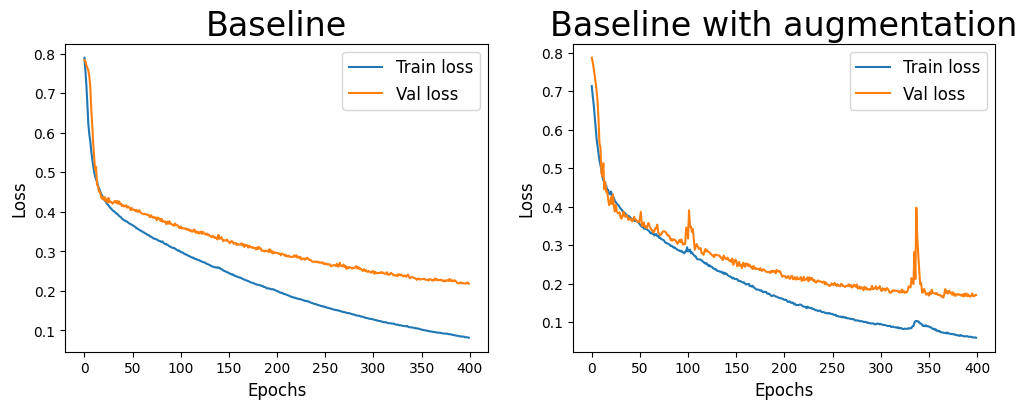

In [ ]:
# Plot history for val_loss, train_loss and epoch for Baseline and Baseline data augmented
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].plot(history_no_aug["Epoch"], history_no_aug["train_loss"], label="Train loss")
axs[0].plot(history_no_aug["Epoch"], history_no_aug["val_loss"], label="Val loss")
axs[0].set_xlabel("Epochs", fontsize=12)
axs[0].set_ylabel("Loss", fontsize=12)
axs[0].set_title("Baseline", fontsize=24)
axs[0].legend(fontsize=12)

axs[1].plot(history_aug["Epoch"], history_aug["train_loss"], label="Train loss")
axs[1].plot(history_aug["Epoch"], history_aug["val_loss"], label="Val loss")
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].set_ylabel("Loss", fontsize=12)
axs[1].set_title("Baseline with augmentation", fontsize=24)
axs[1].legend(fontsize=12)
